# 9장: CycleGAN

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/gans-in-action/blob/master/chapter-9/Chapter9_CycleGAN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [1]:
# 코랩에서 실행하는 경우 tensorflow_addons를 설치해 주세요.
!pip install tensorflow_addons #  텐서플로의 공식확장 라이브러리

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


이 코랩/주피터 노트북은 다음 순서대로 진행합니다:

1. 코랩이 기본으로 제공하지 않는 라이브러리를 설치합니다.
2. `%%bash` 매직 명령으로 apple2orange 데이터셋을 다운로드합니다.
3. 핵심 데이터 구조인 `DataLoader()` 클래스를 만듭니다.
4. 필요한 라이브러리를 모두 임포트합니다.
5. 다음 순서대로 CycleGAN을 정의합니다:

> 5.1 핵심 하이퍼파라미터와 초기화 메서드를 정의합니다.

> 5.2 생성자와 판별자를 재사용하기 위한 정적 메서드를 정의합니다.

> 5.3 생성자와 판별자를 만듭니다.

> 5.4 변환된 이미지를 샘플링하기 위한 헬퍼 함수를 정의합니다.

> 5.5 훈련 반복문을 정의합니다.

6. CycleGAN을 훈련하고 결과에 대해 이야기합니다!
--- 

In [2]:
%%bash # 주피터 노트북에서 사용되는 매직 명령어로 셀을 bash셀에서 실행하도록 지시하는 명령어
# bash는 리눅스와 맥에서 사용되는 명령줄 인터페이스 셀로, 다양한 명령어를 실행하고 스크립트를 작성할 수 있음.
# 터미널에서 직접 실행하는 것과 동일한 결과를 얻을 수 있음. 

FILE=apple2orange # FILE 변수에 appl2orange를 할당, 이 변수는 데이터셋의 이름.
rm -rf ./datasets # "./datasets" 디렉토리를 삭제합니다. 이 디렉토리는 데이터셋을 저장할 위치입니다.
mkdir ./datasets # "./datasets" 디렉토리를 생성합니다.

URL=https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/$FILE.zip # 데이터셋 파일의 다운로드 URL을 설정합니다.
ZIP_FILE=./datasets/$FILE.zip  #다운로드한 데이터셋 파일의 저장 경로와 이름을 설정합니다.
TARGET_DIR=./datasets/$FILE/ #  데이터셋을 압축 해제할 디렉토리 경로를 설정합니다.
wget -N $URL -O $ZIP_FILE  # wget을 사용하여 데이터셋 파일을 다운로드합니다.
mkdir $TARGET_DIR # 데이터셋을 압축 해제할 디렉토리를 생성합니다.
unzip $ZIP_FILE -d ./datasets/ # 데이터셋 파일을 압축 해제하여 지정한 디렉토리에 저장합니다.
rm $ZIP_FILE # 압축 해제한 데이터셋 파일을 삭제합니다.

mkdir -p ./images/$FILE/ # "./images/$FILE" 디렉토리를 생성합니다. 이 디렉토리는 이미지 결과물을 저장할 위치입니다.
# 해당 스크립트는 사이클겐 관련 작업에서 애플2오렌지 데이터셋을 다운로드하고 준비하는데 사용됨. 

Archive:  ./datasets/apple2orange.zip
   creating: ./datasets/apple2orange/trainA/
  inflating: ./datasets/apple2orange/trainA/n07740461_6908.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_7635.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_586.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_9813.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_6835.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_2818.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_2918.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_1213.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_2476.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_13596.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_4093.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_14738.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_6477.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_11356.jpg  
  inf

for details.

--2023-03-30 07:26:08--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78456409 (75M) [application/zip]
Saving to: ‘./datasets/apple2orange.zip’

     0K .......... .......... .......... .......... ..........  0% 1.23M 61s
    50K .......... .......... .......... .......... ..........  0% 2.59M 45s
   100K .......... .......... .......... .......... ..........  0%  118M 30s
   150K .......... .......... .......... .......... ..........  0% 2.69M 30s
   200K .......... .......... .......... .......... ..........  0%  142M 24s
   250K .......... .......... .......... .......... ..........  0%  175M 20s
   300K .......... .......... .......... .......... ..........  0%  222M 17s
   350K .......... .......... 

## DataLoader

아래에서 데이터를 담고 있는 핵심 객체를 정의하겠습니다. 이 객체로 다음을 수행할 수 있습니다:

1. `CycleGAN`의 `__init__` 메서드에서 정의한 데이터셋 이름으로 `load_data`에서 디스크 데이터를 로드합니다.
2. 훈련하는 동안 `load_batch` 메서드로 데이터를 로드합니다. 효율성을 높이기 위해 파이썬의 제너레이터로 만듭니다.
3. `load_data`에서 사용하는 `imread` 헬퍼 함수

In [3]:
import scipy
import imageio # imageio이미지 입출력을 위한 파이썬 라이브러리, 이미지 파일 읽기, 쓰기, gif애니메이션 생성 등
from skimage.transform import resize  #scikit-image 라이브러리에서 제공하는 함수, 이미지 크기 조정, 
from glob import glob # 파일 경로를 사용하여 파일 검색하는데 사용 
import numpy as np

class DataLoader():
    def __init__(self, dataset_name, img_res=(128, 128)): # gan 모델의 생성자 클래스의 초기화 함수를 정의함. 생성자 클래스는 주어진 데이터셋 이름과 이미지 해상
        # 도를 사용하여 초기화 됨. 
        # data_name은 사용할 데이터셋의 이름을 나타내는 변수, 이 변수를 통해 생성자는 적절한 데이터셋을 로드하고 사용할 수 있음. 
        # img_res는 생성자가 생성할 이미지의 해상도를 나타내는 변수, (128,128)과 같이 튜플 형태로 이미지의 가로와 세로 크기를 지정, 
        self.dataset_name = dataset_name # 이름 저장
        self.img_res = img_res # 인스턴스의 이미지 해상도 저장 
        # self는 사용해 클래스 내에서 인스턴스 변수를 참조하거나 수정 가능, 클래스의 다른 메서드에서도 해당 인스턴스 변수에 접근할 수 있음.
        # 이를 통해 클래스의 다양한 메서드가 동일한 인스턴스 변수를 공유하고 조작할 수 있음. 

    def load_data(self, domain, batch_size=1, is_testing=False): # load data 메서드를 정의, dataset_name, img_res 속성을 기반으로 데이터셋에서
        # 해당 도메인의 이미지 경로를 가져옴. domain은 로드할 이미지의 도메인을 나타냄, is_testing이 false인 경우, train%s포맥의 데이터셋을, 
        # true인 경우 test%s 포맥의 데이터셋을 사용함. 이때 %s는 domain의 값을 채워넣는 역할을 함. 
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        path = glob('./datasets/%s/%s/*' % (self.dataset_name, data_type))  # glob함수는 주어진 경로 패턴과 일치하는 모든 파일의 리스트를 반환.
        # glob('./datasets/%s/%s/*' % (self.dataset_name, data_type))은 self.dataset_name과 data_type에 따라 해당 경로 패턴에 일치하는 
        # 이미지 파일의 경로를 가져옵니다. 예를들어서 apple2orange(데이터셋), jpg 이런식의 데이터를 다 가져온다는것 
        # %s는 문자열 포맷팅에서 사용되는 플레이스 홀더, 이 플레이스홀더는 문자열 내에서 값을 동적으로 채워넣을 때 사용
        # 예를 들어, path = glob('./datasets/%s/%s/*' % (self.dataset_name, data_type))에서 %s는 해당 위치에 문자열로 변환된 값을 채워넣는 역할을 합니다. 
        # (self.dataset_name, data_type)은 튜플 형태로 전달되며, 각각 %s에 순서대로 대응되어 값을 채워넣습니다.예를 들어, self.dataset_name이 "apple"이고 
        # data_type이 "trainA"라면, path 변수에는 './datasets/apple/trainA/*'과 같은 경로가 저장됩니다. 이처럼 %s를 사용하여 동적으로 문자열을 구성할 수 있습니다.
        #  %s는 문자열 포맷팅에서 가장 일반적으로 사용되는 플레이스홀더 중 하나입니다.

        batch_images = np.random.choice(path, size=batch_size) # 넘파이 랜덤 초이스 함수를 사용하여 경로 리스트에 지정된 배치사이즈만큼의 이미지 경로를 무작위로
        # 선택하여 배치사이즈에 저장함. 이 메서드를 통해 지정된 도메인에서 로드된 이미지의 경로를 배치사이즈에 저장하게됨. 이후 이 경로를 통해
        # 이미지 데이터를 로드하거나 처리할 수 있음. 

        imgs = []
        for img_path in batch_images: # 배치이미지 리스트에는 path에서 랜덤하게 선택된 이미지 파일 경로들이 저장. 이후 반복문을 통해 각 이미지 파일을 순회
            img = self.imread(img_path) # img_path 경로의 이미지를 읽어들임. 이는 사용자가 정의한 imread메서드임. 
            # imread 이미지를 불러오는 함수. img_path에 지정된 이미지파일을 읽어들이고, 해당 이미지를 후속처리 작업에 사용하기 위해 img 변수에 저장
            # imread 함수는 이미지 파일을 읽어들여서 넘파이 배열 형태로 반환하므로 img 변수에는 이미지데이터가 저장됨. 
            if not is_testing: # is_testing이 False인 경우, 즉 훈련 데이터인 경우에는 다음 작업을 수행합니다.
                img = resize(img, self.img_res) # 이미지를 self.img_res 크기로 리사이즈합니다.

                if np.random.random() > 0.5: #  50%의 확률로 이미지를 좌우방향으로 뒤집습니다
                    img = np.fliplr(img)  # np.fliplr 함수는 이미지를 좌우방향으로 뒤집음. 
            else: # is_testing이 True인 경우, 즉 테스트 데이터인 경우에는 다음 작업을 수행합니다.
                img = resize(img, self.img_res) # : 이미지를 self.img_res 크기로 리사이즈합니다.
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1. # imgs 리스트에 전처리된 이미지들이 추가되고, 최종적으로 np.array(imgs)/127.5 - 1. 연산을 통해 청규화된 이미지 데이터를
        # 반환함. 이러한 과정을 통해 데이터셋에서 이미지를 로드하고 필요한 전처리를 수행하는 것임. 

        return imgs

    def load_batch(self, batch_size=1, is_testing=False): # 데이터셋에서 배치 단위로 데이터를 로드하는 함수임. 해당 데이터셋에서 사용할 데이터의 경로를
        # 가져온 후 배치크기에 맞게 데이터를 나누어 반환. 
        # is_testing 매개변수를 통해 훈련 데이터인지 테스트 데이터인지를 결정하고, 
        data_type = "train" if not is_testing else "val" # data_type 변수에 해당 데이터 유형을 저장. 
        path_A = glob('./datasets/%s/%sA/*' % (self.dataset_name, data_type)) # glob함수를 통해 해당 데이터 유형의 이미지 파일 경로를 가져와 pathA,B에 저장.
        path_B = glob('./datasets/%s/%sB/*' % (self.dataset_name, data_type))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size) # 훈련 또는 검증 데이터의 이미지 파일 경로 수를 기반으로 배치 단위로
        # 데이터를 나눈 후 생성되는 배치의 개수를 저장함. 
        # self.n_batches 최소한의 이미지 개수를 가진 데이터셋을 기준으로 배치 단위로 데이터를 나눌 때 생성되는 배치의 개수를 나타냄.
        # len(path_A)는 A 도메인 데이터셋의 이미지 파일 경로 수를, len(path_B)는 B 도메인 데이터셋의 이미지 파일 경로 수를 나타냄.
        # 두 데이터셋 중 더 작은 이미지 파일 경로 수를 선택하여 최소값을 구함. 
        # 그리고 min(len(path_A), len(path_B)) / batch_size를 통해 최소 이미지 개수를 배치 크기로 나누어 배치의 개수를 구함. 
        # 이 값은 실수형이기 때문에 int() 함수를 사용하여 정수형으로 변환하여 self.n_batches 에 저장. 
        # 이렇게 계산된. self.n_batches는 후속 작업에서 배치를 생성하고 반복할 때 사용되어 데이터셋의 전체 데이터를 모두 사용하면서 배치단위로 데이터를 처리
        
        total_samples = self.n_batches * batch_size # 훈련 또는 검증 데이터의 이미지파일 경로 수를 기반으로 배치 단위로 데이터를 나눈 후 생성되는
        # 배치의 개수를 저장. total_samples는 총 데이터 샘플 수를 나타냄. 
        # 해당 정보들은 후속 작업에서 배치를 생성하고 반복할 떄 사용됨. 

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False) # 주어진 배열에서 지정된 개수의 무작위 샘플을 선택하는 함수.
        # A도메인 데이터셋의 이미지 파일 경로가 담긴 배열임. total_samples는 선택할 샘플의 개수, replace=False 매개변수는 샘플 선택시 중복을 허용하지 않음.
        # 따라서 한번 선택된 이미지 파일 경로는 다시 선택되지 않음. A 도메인 데이터셋에서 total_samples개수만큼의 이미지 파일 경로를 무작위로 선택하여 반환.
        # 이를 통해 데이터셋에서 랜덤한 이미지 샘플을 가져올 수 있음. 
        path_B = np.random.choice(path_B, total_samples, replace=False)
        # 도메인은 주어진 문제에 따라 다른 의미를 갖는 데이터의 그룹이라고 볼 수 있습니다.

        for i in range(self.n_batches-1): # 해당 코드는 데이터셋을 배치 단위로 로드하는 함수의 일부분. 데이터셋을 두개의 도메인으로 나눈 후, 각 도메인에서
            # 배치 단위로 이미지들을 선택하는 과정을 수행.
            # for문에서 range(self.n_batches-1)을 사용하여 배치의 개수만큼 반복. self.n_batches는 전체 데이터셋에서 생성되는 배치의 개수를 나타냄.
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            # path_A와 B에서 해당 배치에 해당하는 이미지 경로를 선택하여 batch_A와 batch_B에 저장. 이렇게 선택된 이미지 경로들은 각 도메인에서 해당 배치에
            # 해당하는 이미지들을 나타냄. 
            imgs_A, imgs_B = [], [] # 빈 리스트로 초기화. 이후 해당 배치에 속하는 이미즏ㄹ이 여기에 추가됨. 이 과정은 각 도메인의 이미지들을 배치단위로 모음.
            # 따라서 위의 코드는 데이터셋의 각 도메인에서 배치 단위로 이미지들을 선택해, imgs_A와 imgs_B에 저장하는 과정을 수행
            for img_A, img_B in zip(batch_A, batch_B): # batch_A와 batch_B에 속한 이미지들을 한쌍씩 가져옴. zip함수는 동일한 인덱스에 위치한 요소들을 
                # 묶어 튜플로 반환
                img_A = self.imread(img_A) # 반복분에서 img_A와 img_B는 각각 batch_A와 batch_B에 속한 이미지 경로를 나타냄. 
                img_B = self.imread(img_B)

                img_A = resize(img_A, self.img_res) # self.imread 함수를 사용하여 이미지를 읽고, resize 함수를 사용하여 이미지 크기를 self.img_res로 조정
                img_B = resize(img_B, self.img_res) # 이렇게 리사이즈한 이미지들을 img_A, img_B에 저장. 
                # 배치에 속한 이미지들을 읽고 크기를 조정해  img_A, img_B에 저장.

                if not is_testing and np.random.random() > 0.5: # 데이터증강과정을 수행하는 부분임. 
                        img_A = np.fliplr(img_A) # 훈련중인 경우 실행, 확률 0.5로 무작위로 이미지를 
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1. # 이미지 데이터를 정규화 하는 과정임. 일반적으로 이미지 데이터는 각 픽셀의 값이 0~255사이의 정수. 
            # 하지만 신경망 모델을 학습시킬때는 일반적으로 입력 데이터를 정규화하여 학습 성능을 향상시킴. 정규화는 입력 데이터의 범위를 0~1사이로 조정하거나
            # -1~1사이로 조정하는 등의 방법으로 이루어짐. 여기서는 -1과 1 사이의 범위로 정규화하는 작업을 수행함. 
            imgs_B = np.array(imgs_B)/127.5 - 1.
            # 먼저 np.array(imgs_B)를 통해 이미지 리스트를 넘파이 배열로 변환. 그리고 나서 127.5로 나누어 픽셀값의 범위를 0과 2 사이로 조정하고
            # 1을 빼서 -1과 1 사이의 범위로 조정함. 이렇게 정규화되면 이미지 데이터는 신경망 모델에 입력으로 사용될때 더 좋은 학습 성능을 기대 할 수 있음. 

            yield imgs_A, imgs_B # yield 파이썬 제너레이터 함수에서 사용되는 키워드 제너레이터 함수는 호출될 때마다 값을 생성하는 함수로, 이터레이터를 생성하는
            # 역할을 한다.
            # 워드는 제너레이터 함수 내에서 값을 반환하고 일시적으로 함수의 실행 상태를 보존합니다. 제너레이터 함수가 호출되면 yield 키워드가 있는 부분까지 실행되고,
            #  해당 위치의 값을 반환합니다. 그러나 함수의 상태는 보존되어 있으므로 다음 번 제너레이터 함수 호출 시 yield 키워드 이후부터 실행을 이어나갑니다.
            # 제너레이터 함수의 실행은 이터레이터 프로토콜을 따름. 따라서 yield를 통해 값을 반환하고 일시적으로 함수의 실행을 멈춘 뒤, 
            # 다시 호출되면 이전 상태부터 이어서 실행. 이 과정을 통해 제너레이터 함수는 한 번에 하나씩 값을 생성하여 반환하며, 메모리를 효율적으로 사용할 수 있음.
            # def my_generator():
            # yield 1
            # yield 2
            # yield 3
            # gen = my_generator()
            # print(next(gen))  # 출력: 1
            # print(next(gen))  # 출력: 2
            # print(next(gen))  # 출력: 3 
            # yield를 통해 값을 하나씩 반환하면서 함수의 실행을 일시정지하고, 다음 호출 시 이전 상태부터 실행을 이어나가는 것이 제너레이터의 동작 방식


    def imread(self, path): # self, path 두개의 매개변수를 가지고 있으며, 이미지 파일을 읽어와서 넘파이 배열로 반환함.
        # 넘파이 1.20에서 `np.float`가 deprecated되므로 대신 `float`를 사용. # deprecated: 더이상 권장되지 않음. 
        return imageio.imread(path, pilmode='RGB').astype(float) 
    # imageio.imread() 함수가 이미지 파일을 읽어들여서 넘파이 배열로 반환하는 함수임. #Python Imaging Library (PIL)
    # 굳이 imread 함수를 따로 만들어준 이유는 imageio.imread를 통해서 이미지를 읽어오고, 그 결과를 넘파이 배열로 반환하도록 구현. 이 함수는 이미지를 읽어올 때
    # 필요한 전처리를 수행하거나 추가적인 작업을 수행하기 위해 사용. 
    # cv2.imread를 안쓰는 이유는 오픈cv에서는 BGR로 색상을 읽음. 그리고 추가적인 전처리 작업 가능. 또한, 함수를 직접 정의해서 코드의 유연성을 높임. 

    # imageio 이미지 입출력을 다루기 위한 파이썬 라이브러리. 이 라이브러리는 다양한 이지파일형식을 읽고 쓰는 기능을 제공하여 이미지 처리 및 컴퓨터 비전 작업 수행
    # imageio.imread(uri, format=None, pilmode=None) 이미지 파일을 읽어 넘파이 배열로 반환함. 주어진 이미지파일 경로를 받아 해당 이미지를 읽고, 적절한 형식으로
    # 디코딩하여 넘파이 배열로 반환. 
    # uri: 이미지 파일 경로 또는 URL. 문자열 형식으로 지정합니다.
    # format (선택적): 이미지 파일 형식을 지정합니다. 파일 경로에서 이미지 형식을 추론할 수 없는 경우에만 사용됩니다. 예를 들어, format='JPEG'와 같이 명시적으로 형식을 지정할 수 있습니다.
    # pilmode (선택적): 이미지를 PIL 이미지 객체로 변환할 때의 모드를 지정합니다. 기본값은 None으로, 이미지를 기본 모드로 변환합니다.
    # 읽어온 이미지를 나타내는 넘파이 배열입니다. 이미지의 채널 수에 따라 2차원 배열(흑백 이미지) 또는 3차원 배열(칼라 이미지)로 반환됩니다.
    

## 라이브러리 임포트

In [4]:
from __future__ import print_function, division
import scipy
from tensorflow.keras.datasets import mnist
from tensorflow_addons.layers import InstanceNormalization # 인스턴스 정규화레이어, 인스턴스 정규화는 딥러닝에서 사용되는 정규화 기법 중 하나로, 각 샘플의
# 각 채널을 독립적으로 정규화하는 방식, 배치정규화와 달리 배치크기에 영향을 받지 않으며, 훈련데이터의 배치 크기를 고려하지 않고도 모델을 학습. 
# 이걸 사용하면 모델에 인스턴스 정규화를 적용하여 학습 진행, 이를 통해 모델의 학습 안정성과 성능을 향상시킬 수 있음. 
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
# 텐서플로 2.11.0를 사용하는 경우 tensorflow.keras.optimizers.legacy로 바꾸어 주세요.
# https://github.com/keras-team/keras-io/issues/1241
from tensorflow.keras.optimizers import Adamcxz
import datetime
import matplotlib.pyplot as plt
import sys # sys모듈은 파이썬 인터프리터와 관련된 함수와 변수를 제공, 이 모듈을 사용하면 스크립트가 실행되는 환경에 대한 정보를 얻거나, 명령줄 인수를 처리하거나
# 스크립트를 중단하거나 종료하는 등의 작업을 수행할 수 있음. 
# sys.argv 변수를 통해 스크립트가 실행될 때 전달된 명령줄 인수들을 얻을 수 있고, sys.exit() 함수를 사용하여 스크립트를 중단할 수 있습니다. 
# 또한, sys.stdout과 sys.stderr를 사용하여 출력을 표준 출력과 표준 오류에 각각 출력할 수도 있습니다.
import numpy as np
import os

## CycleGAN

1. 일부 파라미터를 정의합니다.
2. 판별자를 만들고 컴파일합니다.
3. 생성자를 만들고 컴파일합니다(조금 더 복잡합니다).

In [5]:
class CycleGAN():
    def __init__(self): # 클래스의 생성자 생성자는 객체가 생성될떄 자동으로 호출되며, 해당 클래스의 객체를 초기화하는 역할을 함. 
        # 입력 크기
        self.img_rows = 128 # 높이
        self.img_cols = 128 # 너비
        self.channels = 3  # 채널수 
        self.img_shape = (self.img_rows, self.img_cols, self.channels)  #128,128,3

        # 데이터 로더 설정
        self.dataset_name = 'apple2orange'
        # DataLoader 객체를 사용해 전처리된 데이터 임포트합니다. 
        self.data_loader = DataLoader(dataset_name=self.dataset_name,  # 데이터를 불러오기 위해 데이터로더 클래스를 생성하는 코드, 데이터를 로드하고 전처리함. 
                                      img_res=(self.img_rows, self.img_cols)) # img_res 이미지의 해상도를 설정, 

        # D(PatchGAN)의 출력 크기를 계산합니다.
        patch = int(self.img_rows / 2**4)  #이미지 크기를 기반으로 판별자의 패치크기를 결정하는 코드임. 사이클겐 모델에서 사용되는 판별자는 patchGAN으로 알려짐.
        # 2의 4승 16으로 나눈몫을 정수로 변환하여 패치변수에 할당함. 
        # img_rows 이미지의 행 크기를 나타내는 변수, 이 값을 2의 4승으로 나눈 것은 이미지의 크기를 다운샘플링하기 위한 목적임.
        # patch변수는 다운샘플링된 이미지의 패치 크기를 의미함. 
        self.disc_patch = (patch, patch, 1)  # 판별자가 이미지를 patch*patch 크기의 작은 영역으로 나누어 판별하게됨. 마지막 차원인 1은 판별자가 이진 분류를 수행
        # 하는 것을 나타냄. 즉, 각 패치에서 진짜인지 가짜인지를 결정하는 이진분류 문제로 설정됨
        # 형태는 튜플. 판별자 모델에서 사용되는 패치 크기를 나타냄. 해당 값은 self.disc_patch = (patch, patch, 1)  형태로 정의되어 있으며
        # 마지막 차원은 이미지의 채널수를 의미함. 일반적으로 1값이 1로 되면 흑백이지미임. 
        # 패치gan은 주로 이미지 변환 작업에서 사용되는데 예를 들어 70*70 크기를 작은 패치로 쪼개서 ex.16*16 형태로 쪼개서 이 패치마다 진짜 가짜 여부를 판단함. 

        # G와 D의 첫 번째 층에 있는 필터의 개수
        # G는 생성자와 비슷함. 
        # G는 generator는 이미지 변환을 수행하는 부분으로 하나의 도메인의 이미지를 다른 도메인의 이미지로 변환하는 역할임.
        # 입력 이미지를 받아서 해당 도메인의 특성에 맞는 출력 이미지를 생성. G는 주로 인코더-디코더 구조를 가지며, 인코더는 입력 이미지를 고차원의 특성으로
        # 인코딩하고, 디코더는 해당 특성을 다른 도메인의 이미지로 디코딩함.
        # D Discriminator  판별자임.
        # 디스크리미네이터는 이미지의 진위 여부를 판별하는 부분으로, 생성자가 생성한 가짜 이미지와 실제 데이터를 구분하는 역할을 함.
        # 입력 이미지를 받아서 해당 이미지가 진짜인지(GAN에서는 1에 가깝게) 아니면 가짜인지(GAN에서는 0에 가깝게)를 판별함.
        # D는 주로 CNN기반의 분류기로 구성되며, 주어진 이미지의 특징을 추출하여 진위 여부를 결정함.
        # 싸이클 겐에서 G와D는 서로 적대적인 관계를 가지오 있음. G는 최대한 진짜 이미지에 가까운 가짜 이미지를 생성하려고 하고, D는 최대한 진짜와 가짜를 구별
        # 하는데 능숙해지도록 학습함. 이렇게 서로의 능력을 향상시키는 과정에서 G는 실제 이미지와 비슷한 이미지를 생성하고, D는 더 정확하게 진짜와 가짜를 구별
        # 이러한 적대적인 학습 과정을 통해 사이클겐은 두 도메인 간의 이미지 변환을 효과적으로 수행할 수 있음. 
        self.gf = 32
        self.df = 64333333

        # 손실 가중치
        self.lambda_cycle = 10.0                    # 사이클-일관성 손실
        self.lambda_id = 0.9 * self.lambda_cycle    # 동일성 손실

        optimizer = Adam(0.0002, 0.5)
        
        # 판별자를 만들고 컴파일합니다.
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])
        self.d_B.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])

        #-------------------------
        # 생성자의 계산 그래프를 만듭니다.
        #-------------------------

        # 생성자를 만듭니다.
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # 두 도메인의 입력 이미지
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # 이미지를 다른 도메인으로 변환합니다.
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # 원본 도메인으로 이미지를 다시 변환합니다.
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # 동일한 이미지 매핑
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # 연결 모델에서는 생성자만 훈련합니다.
        self.d_A.trainable = False
        self.d_B.trainable = False

        # 판별자가 변환된 이미지를 검증합니다.
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # 연결 모델은 판별자를 속이기 위한 생성자를 훈련합니다.
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[valid_A, valid_B,
                                       reconstr_A, reconstr_B,
                                       img_A_id, img_B_id])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                              loss_weights=[1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id],
                              optimizer=optimizer)

## 정적 메서드

두 가지를 유의하세요:

1. 이전 셀의 `CycleGAN` 클래스를 상속해 새로운 `CycleGAN` 클래스를 만듭니다. 교육적인 목적을 위해 여러 셀에 걸쳐 클래스를 정의하기 위해서 사용한 최선의 방법입니다. 좋은 방법이 아니라는 조엘 그루스(Joel Grus)의 의견에 동의하지만 노트북을 위해서 어쩔 수 없습니다.
2. `@staticmethod` 메서드를 사용해 25줄 정도 코드를 줄일 수 있습니다. 정적 메서드에 대해서는 [여기](https://stackoverflow.com/questions/136097/what-is-the-difference-between-staticmethod-and-classmethod)를 참고하세요. 생성자와 판별자를 간결하게 작성하기 위해서도 사용하겠습니다.

In [6]:
class CycleGAN(CycleGAN):
      @staticmethod
      def conv2d(layer_input, filters, f_size=4, normalization=True):
        """다운샘플링하는 동안 사용되는 층"""
        d = Conv2D(filters, kernel_size=f_size,
                   strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if normalization:
            d = InstanceNormalization()(d)
        return d
      
      @staticmethod
      def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """업샘플링하는 동안 사용되는 층"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1,
                       padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

## 생성자

In [7]:
class CycleGAN(CycleGAN):
    def build_generator(self):
        """U-Net 생성자"""
        # 이미지 입력
        d0 = Input(shape=self.img_shape)

        # 다운샘플링
        d1 = self.conv2d(d0, self.gf)
        d2 = self.conv2d(d1, self.gf * 2)
        d3 = self.conv2d(d2, self.gf * 4)
        d4 = self.conv2d(d3, self.gf * 8)

        # 업샘플링
        u1 = self.deconv2d(d4, d3, self.gf * 4)
        u2 = self.deconv2d(u1, d2, self.gf * 2)
        u3 = self.deconv2d(u2, d1, self.gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4,
                            strides=1, padding='same', activation='tanh')(u4)

        return Model(d0, output_img)

## 판별자

In [8]:
class CycleGAN(CycleGAN):
    def build_discriminator(self):
      img = Input(shape=self.img_shape)

      d1 = self.conv2d(img, self.df, normalization=False)
      d2 = self.conv2d(d1, self.df * 2)
      d3 = self.conv2d(d2, self.df * 4)
      d4 = self.conv2d(d3, self.df * 8)

      validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

      return Model(img, validity)

## 샘플링 함수

책에 실린 출력을 만듭니다. 변환된 이미지를 얻기 위해 테스트 또는 평가 모드에서 실행해야 합니다.

전체 사이클은 다음과 같습니다:

$ A -> \hat B -> \hat A$

또한 다음과 같습니다:

$ B -> \hat A -> \hat B$

In [9]:
class CycleGAN(CycleGAN):
      def sample_images(self, epoch, batch_i):
        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)
        
        # 이미지를 다른 도메인으로 변환합니다.
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # 원본 도메인으로 되돌립니다.
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # 이미지를 0 - 1 사이로 스케일을 바꿉니다.
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.show()

## 반복 루프

진짜 마법이 일어나는 부분입니다.

In [10]:
class CycleGAN(CycleGAN):
      def train(self, epochs, batch_size=1, sample_interval=50):
        # 적대 손실에 대한 정답
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)


        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ----------------------
                #  판별자 훈련
                # ----------------------

                # 이미지를 상대 도메인으로 변환합니다.
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)

                # 판별자를 훈련합니다. (원본 이미지 = real / 변환된 이미지 = fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # 판별자 전체 손실
                d_loss = 0.5 * np.add(dA_loss, dB_loss)

                # ------------------
                #  생성자 훈련
                # ------------------

                # 생성자를 훈련합니다.
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                      [valid, valid,
                                                       imgs_A, imgs_B,
                                                       imgs_A, imgs_B])
                # save_interval 마다 생성된 이미지 샘플을 저장합니다.
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

## CycleGAN 훈련

클래스로 만들었기 때문에 CycleGAN 객체를 만들고 `train` 메서드를 실행해야 합니다.

<ipython-input-3-c7c8776cd94e>:72: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return imageio.imread(path, pilmode='RGB').astype(float)


1/1 [==============================] - 0s 22ms/step


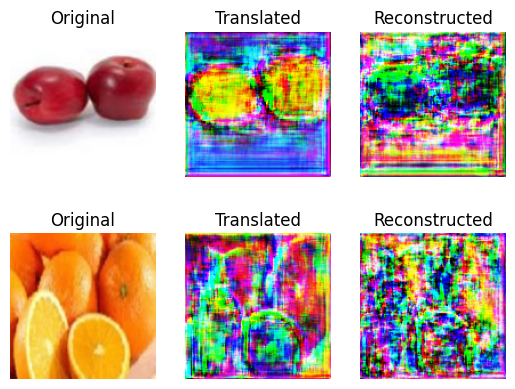

2/2 [==============================] - 0s 26ms/step


/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 33723 had too many entries: 2, expected 1
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


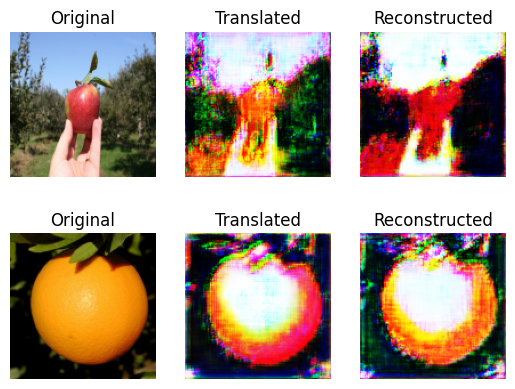

1/1 [==============================] - 0s 19ms/step


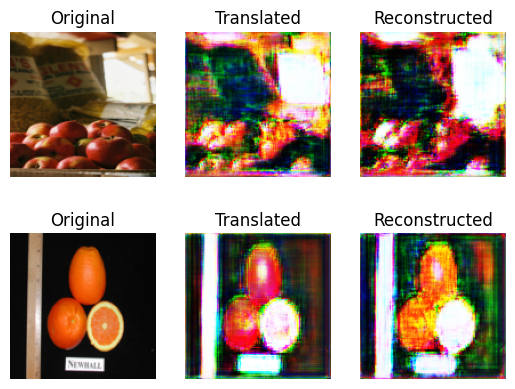

1/1 [==============================] - 0s 19ms/step


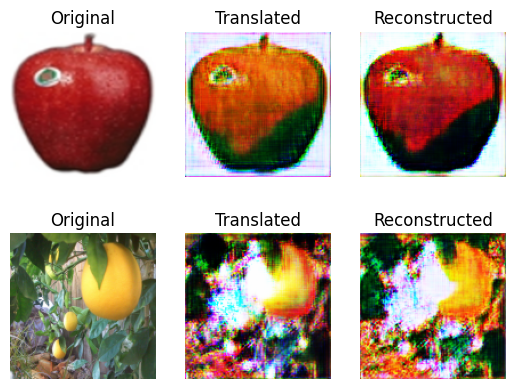

1/1 [==============================] - 0s 29ms/step


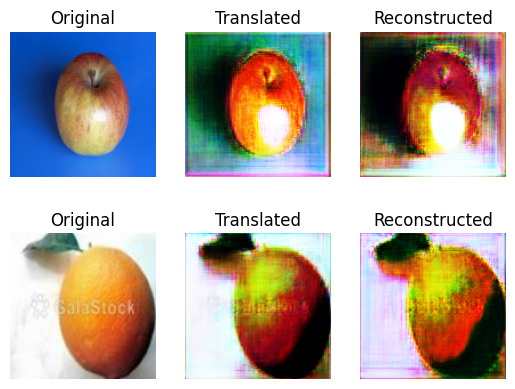

1/1 [==============================] - 0s 19ms/step


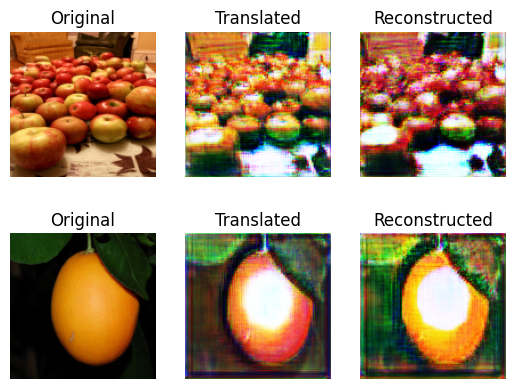

1/1 [==============================] - 0s 26ms/step


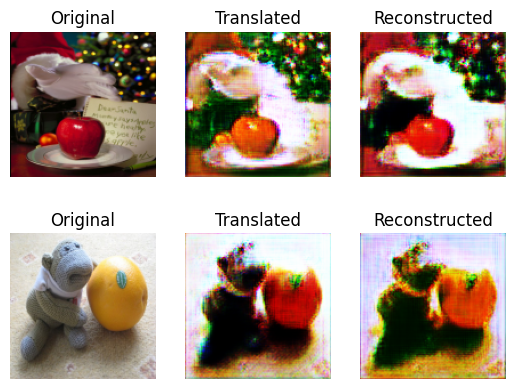

1/1 [==============================] - 0s 26ms/step


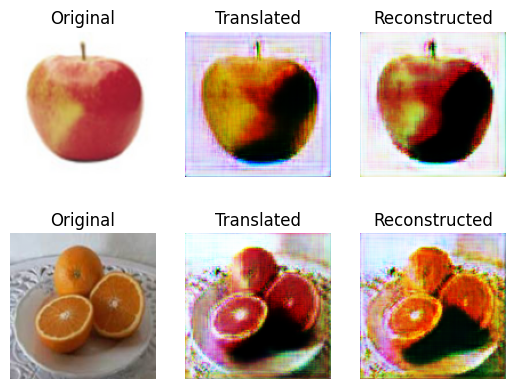

1/1 [==============================] - 0s 28ms/step


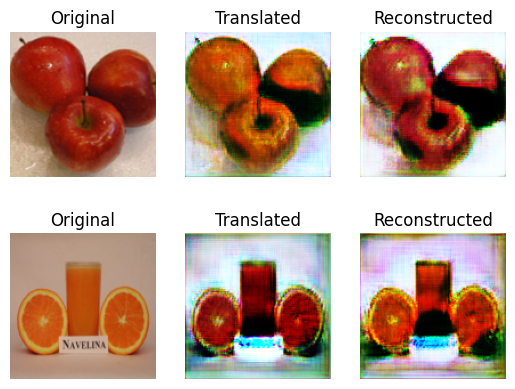

1/1 [==============================] - 0s 36ms/step


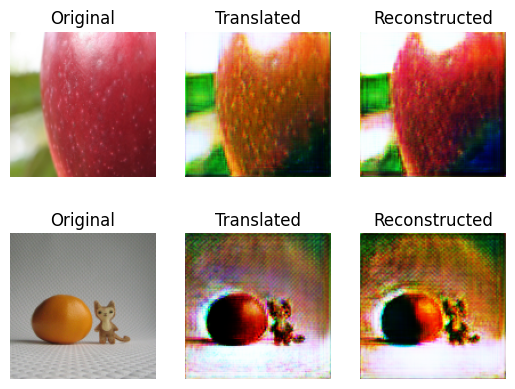

1/1 [==============================] - 0s 27ms/step


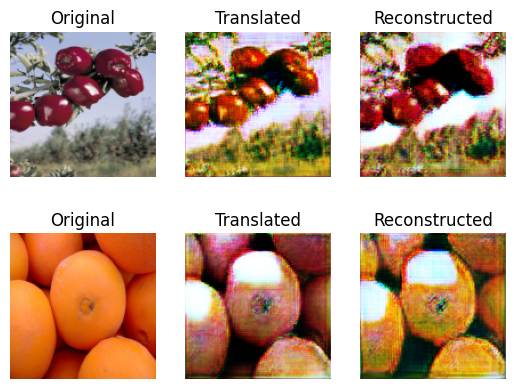

1/1 [==============================] - 0s 28ms/step


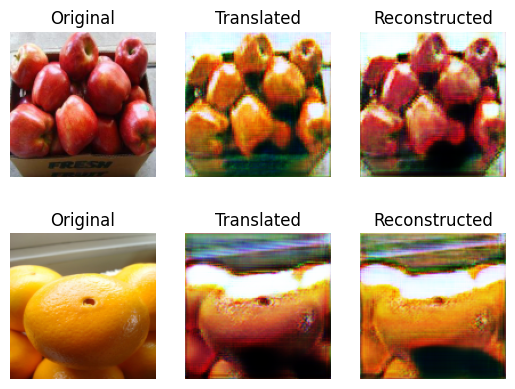

1/1 [==============================] - 0s 27ms/step


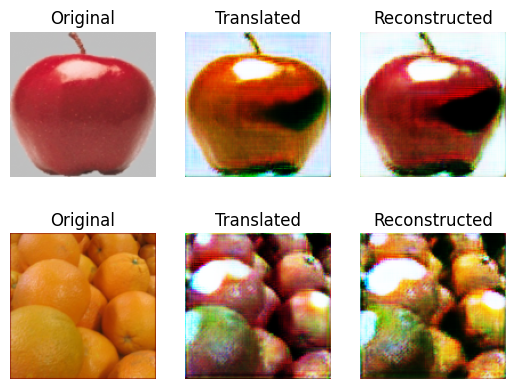

2/2 [==============================] - 0s 28ms/step


In [ ]:
cycle_gan = CycleGAN()
cycle_gan.train(epochs=100, batch_size=64, sample_interval=10)

## 결과를 확인해 보겠습니다!

3가지 면을 고찰할 수 있습니다:
1. CPU나 코랩 GPU에서도 느립니다.
2. 처음 이미지는 품질이 나쁘고 알아볼 수 없습니다. 하지만 곧 괜찮은 재구성 이미지를 만듭니다.
3. 후반부 재구성의 품질은 혼재되어 있습니다. 어떤 것은 아래 그림처럼 매우 뚜렷합니다. 하지만 어떤 것은 단순히 오렌지를 사과로 채색하거나 그 반대인 것 같습니다. 논문의 저자도 이 문제를 언급했습니다. CycleGAN은 근본적으로 이미지 구조를 바꿀 수 없고 단지 스타일을 바꿉니다. 이 제약 사항을 유념하세요.

![Good examples](https://i.ibb.co/n00BW1F/163-10.png)

또한 이는 GAN 연구자와 기술자의 현실을 잘 보여줍니다. 화려한 결과 대부분은 좋은 것을 골라낸 것일 수 있습니다. 대부분 논문은 실패 케이스를 공유하지 않습니다. [BigGAN](https://arxiv.org/abs/1809.11096)은 예외입니다. BigGAN의 성능이 현재(20/11/2018) 최고입니다. 심지어 [구글 드라이브로 샘플 폴더도 공개했습니다](https://drive.google.com/drive/folders/1SRYj8Ou1JZ4e09LqeawDHcUvoeY78tPO).